In [1]:
import xml.etree.ElementTree as ET
from collections import defaultdict
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Define the target LineColor values
#65280:cortical_interstitum
#16776960:medullary_interstitium
#65535:non-Globally sclerotic glomeruli
#255:Globally sclerotic glomeruli
#16711680:tubules
#33023:ateries/arterioles
line_colors = {65280, 16776960, 65535, 255, 16711680, 33023}

In [3]:
# Load and parse the XML file (test)
in_path = "/home/ec2-user/SageMaker/mapping/hubmap-data/Healthy-data/"
in_sample = "91649"
in_xml = os.path.join(in_path, f"{in_sample}.xml")
tree = ET.parse(in_xml)
root = tree.getroot()

In [4]:
# Dictionary to store counts (test sample: 91649)
region_counts = defaultdict(int)

# Iterate over all Annotation elements
for annotation in root.findall(".//Annotation"):
    line_color = annotation.get("LineColor")
    if line_color is not None:
        try:
            color = int(line_color)
            if color in line_colors:
                region_count = len(annotation.findall(".//Region"))
                region_counts[color] += region_count
        except ValueError:
            print(f"Skipping invalid LineColor value: {line_color}")

# Print results
for color, count in region_counts.items():
    print(f"LineColor {color}: {count} Regions")

LineColor 65280: 904 Regions
LineColor 16776960: 749 Regions
LineColor 65535: 752 Regions
LineColor 255: 24 Regions
LineColor 16711680: 43301 Regions
LineColor 33023: 1361 Regions


In [5]:
# Calculate and print the ratio
non_sclerotic = region_counts[65535]  # Non-globally sclerotic glomeruli
sclerotic = region_counts[255]        # Globally sclerotic glomeruli

if sclerotic > 0:  # Avoid division by zero
    ratio = non_sclerotic / sclerotic
    print(f"\n{in_sample} Ratio (Non-sclerotic/Sclerotic): {ratio:.2f}")
else:
    print("\n{in_sample} Ratio (Non-sclerotic/Sclerotic): Cannot calculate (zero sclerotic glomeruli)")


91649 Ratio (Non-sclerotic/Sclerotic): 31.33


In [6]:
# Calculate and print the ratio
non_sclerotic = region_counts[65535]  # Non-globally sclerotic glomeruli
sclerotic = region_counts[255]        # Globally sclerotic glomeruli

if sclerotic > 0:  # Avoid division by zero
    ratio = non_sclerotic / sclerotic
    print(f"\n{in_sample} Ratio (Non-sclerotic/Sclerotic): {ratio:.2f}")
else:
    print("\n{in_sample} Ratio (Non-sclerotic/Sclerotic): Cannot calculate (zero sclerotic glomeruli)")


91649 Ratio (Non-sclerotic/Sclerotic): 31.33


In [ ]:
def parse_xml_for_region_counts(xml_path, line_colors):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    region_counts = defaultdict(int)
    
    for annotation in root.findall(".//Annotation"):
        line_color = annotation.get("LineColor")
        if line_color is not None:
            try:
                color = int(line_color)
                if color in line_colors:
                    region_count = len(annotation.findall(".//Region"))
                    region_counts[color] += region_count
            except ValueError:
                print(f"Skipping invalid LineColor value: {line_color}")
    
    return region_counts

def process_all_xml_files(in_path, line_colors):
    xml_files = [f for f in os.listdir(in_path) if f.endswith(".xml")]
    data = {}
    
    for xml_file in xml_files:
        sample_name = os.path.splitext(xml_file)[0]
        print (sample_name)
        xml_path = os.path.join(in_path, xml_file)
        region_counts = parse_xml_for_region_counts(xml_path, line_colors)
        data[sample_name] = region_counts
    
    df = pd.DataFrame.from_dict(data, orient="index").fillna(0).astype(int)
    return df

result_df = process_all_xml_files(in_path, line_colors)
print(in_path)
print(result_df)

91726
91720
91710
H19-04732_1B1_PAS


In [7]:
#multi-processing 
from multiprocessing import Pool
def parse_xml_for_region_counts(xml_path, line_colors):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    region_counts = defaultdict(int)
    
    for annotation in root.findall(".//Annotation"):
        line_color = annotation.get("LineColor")
        if line_color is not None:
            try:
                color = int(line_color)
                if color in line_colors:
                    region_count = len(annotation.findall(".//Region"))
                    region_counts[color] += region_count
            except ValueError:
                print(f"Skipping invalid LineColor value: {line_color}")
    
    return os.path.basename(xml_path), region_counts

def process_all_xml_files(in_path, line_colors):
    xml_files = [os.path.join(in_path, f) for f in os.listdir(in_path) if f.endswith(".xml")]
    
    with Pool() as pool:
        results = pool.starmap(parse_xml_for_region_counts, [(xml_file, line_colors) for xml_file in xml_files])
    
    data = {os.path.splitext(sample_name)[0]: region_counts for sample_name, region_counts in results}

    df = pd.DataFrame.from_dict(data, orient="index").fillna(0).astype(int)
    return df

result_df = process_all_xml_files(in_path, line_colors)
print(in_path)
print(result_df)


/home/ec2-user/SageMaker/mapping/hubmap-data/Healthy-data/
                   65280     16776960  65535     255       16711680  33023   
91726                  5853      5923       662       182     81091      3012
91720                  4064      1477       326        12     29165      2776
91710                  1927      1605       418        31     41233      2764
H19-04732_1B1_PAS     19166      2554       452        50     65130      2527
H19-12283_1E1_PAS      7623      2598       506        13     57862      4777
91728                 12641      4419       461        45     51896      4282
91730                  8133      4418       899        33     82617      4818
91716                  5589      2231       441        20     50571      5709
91651                  4091      3226       244        37     47546      3317
91740                  2082       899       319         9     30245      1096
91746                  4471      2003       446        71     31481       883
91708

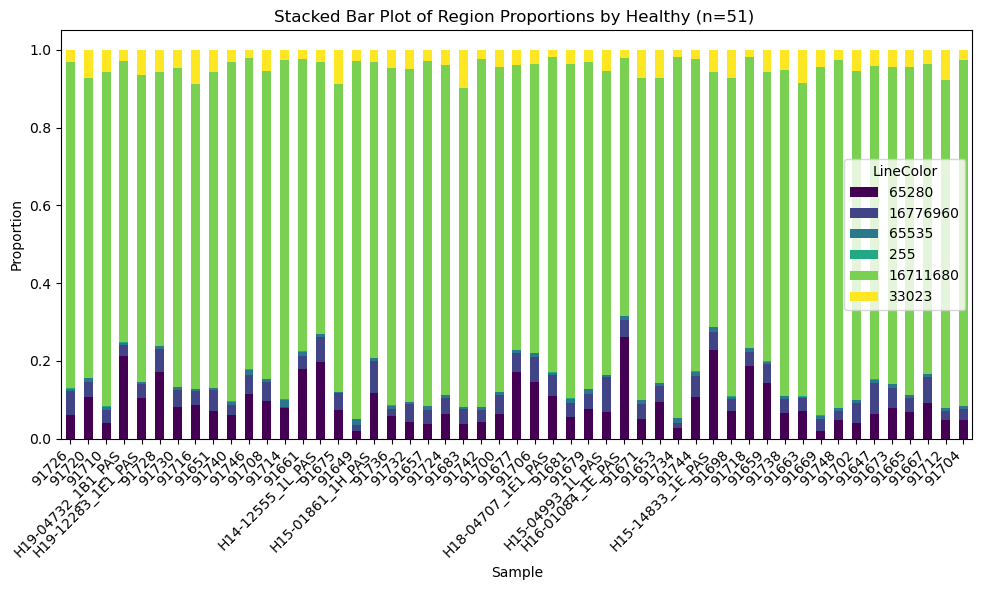

In [9]:
result_df.to_csv("output_results.healthy.csv")
def plot_stacked_bar(df):
    proportion_df = df.div(df.sum(axis=1), axis=0) 
    proportion_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.xlabel("Sample")
    plt.ylabel("Proportion")
    plt.title("Stacked Bar Plot of Region Proportions by Healthy (n=51) ")
    plt.legend(title="LineColor")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
# plot stacked bar 
plot_stacked_bar(result_df)

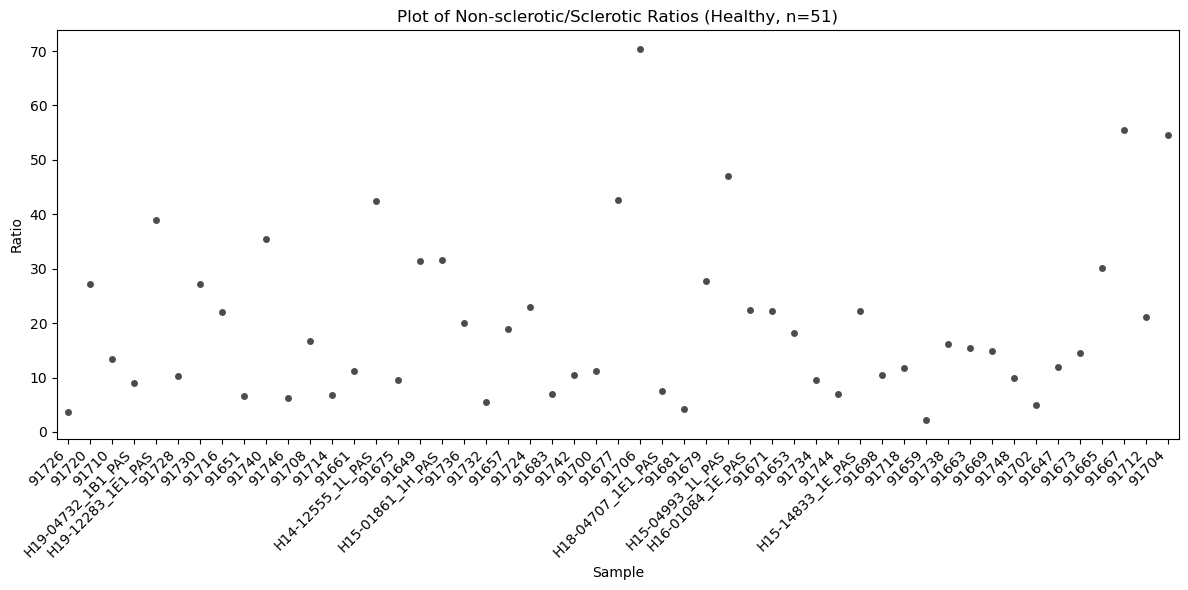

In [11]:
import seaborn as sns
def calculate_ratios_from_df(df, non_sclerotic_color=65535, sclerotic_color=255):
    """Calculates the ratio of non-sclerotic to sclerotic regions using the provided DataFrame."""
    ratios = {}
    for sample, row in df.iterrows():
        non_sclerotic = row.get(non_sclerotic_color, 0)
        sclerotic = row.get(sclerotic_color, 0)

        if sclerotic > 0:
            ratio = non_sclerotic / sclerotic
            ratios[sample] = ratio
        else:
            ratios[sample] = "Cannot calculate (zero sclerotic glomeruli)"
    return ratios

# Example usage (replace with your actual in_path and line_colors)
line_colors = [65535, 255]  # Example line colors

ratios = calculate_ratios_from_df(result_df) # Use the DataFrame

# Create a DataFrame from the ratios dictionary
ratio_df = pd.DataFrame(list(ratios.items()), columns=['Sample', 'Ratio'])
ratio_df = ratio_df[ratio_df['Ratio'] != 'Cannot calculate (zero sclerotic glomeruli)'] #제외
ratio_df.to_csv("output_ratios.healthy.csv")
# Create jitter plot using seaborn
plt.figure(figsize=(12, 6)) # x축 폭을 넓게 설정
sns.stripplot(x='Sample', y='Ratio', data=ratio_df, jitter=True, color='black', alpha=0.7)
plt.title('Plot of Non-sclerotic/Sclerotic Ratios (Healthy, n=51)')
plt.ylabel('Ratio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()